## imports

In [2]:
!pip install -U git+https://github.com/gatto/ds-bigdata.git
!pip install rich
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/Europe/Rome /etc/localtime
!date
!pip install geopandas
!pip install pygeos
!pip install shap
from extractbda import Bikes
import numpy as np
import pandas as pd
import geopandas as gpd
import geopy
import pygeos
from shapely.geometry import LineString, Point, Polygon
import folium
from folium.features import DivIcon
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_squared_error,r2_score)
from rich import print
from rich.console import Console
from rich.table import Table
import shap
import pickle
console = Console()

  Cloning https://github.com/gatto/ds-bigdata.git to /tmp/pip-req-build-9sjb94iz
  Running command git clone -q https://github.com/gatto/ds-bigdata.git /tmp/pip-req-build-9sjb94iz
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for extractbda: filename=extractbda-0.5-py3-none-any.whl size=547832 sha256=5b8dcfa875dae555546faa52d2c495ef3156743132e18ff44f77d8926517ac85
  Stored in directory: /tmp/pip-ephem-wheel-cache-0vnu1c5q/wheels/65/87/46/3bd8b72398b13604298d6babe6e2c27b9704ca35bd2ecaae98
Successfully built extractbda
     |████████████████████████████████| 214 kB 4.3 MB/s 
     |████████████████████████████████| 51 kB 2.8 MB/s 
Tue Dec 14 23:07:46 CET 2021
     |████████████████████████████████| 1.0 MB 4.2 MB/s 
     |████████████████████████████████| 6.3 MB 39.6 MB/s 
     |████████████████████████████████| 15.4 MB 42.1 MB/s 
     |████████████████████████████████| 2.1 MB 3.6 MB/s 
     |██

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Rental Bikes: Explanations of the `RandomForestRegressor`

## Spatial assignments: 11 zones

In [4]:
def read_geodf(filename):
    df= pd.read_csv(filename)
    
    geometry = [Point(xy) for xy in zip(df.long, df.lat)]
    df['geometry']= geometry
    
    crs = {'init': 'epsg:4326'}
    geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    
    return geo_df

In [5]:
part11= gpd.read_file('/content/drive/Shareddrives/BigData_project/data/partition11.geojson')
part21= gpd.read_file('/content/drive/Shareddrives/BigData_project/data/partition21.geojson')
geo_df= read_geodf('/content/drive/Shareddrives/BigData_project/data/stations.csv')

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6


In [6]:
part11.head(10)

name                                           geometry
0   Alexandria  POLYGON ((-77.14436 38.81036, -77.14397 38.810...
1    DC Ward 8  POLYGON ((-76.97229 38.87286, -76.97240 38.872...
2    DC Ward 6  POLYGON ((-77.01790 38.91410, -77.01801 38.914...
3    DC Ward 7  POLYGON ((-76.94186 38.91854, -76.94200 38.918...
4    DC Ward 2  POLYGON ((-77.04946 38.91999, -77.04973 38.920...
5    DC Ward 1  POLYGON ((-77.03523 38.93743, -77.03570 38.937...
6    DC Ward 5  POLYGON ((-76.99144 38.95730, -76.99163 38.957...
7    DC Ward 3  POLYGON ((-77.05808 38.95676, -77.05809 38.956...
8    DC Ward 4  POLYGON ((-77.04097 38.99597, -77.07174 38.971...
9  Arlington 1  POLYGON ((-77.17217 38.89333, -77.17189 38.893...

In [7]:
m = folium.Map(location=[geo_df['lat'].mean(), geo_df['long'].mean()],
               tiles='OpenStreetMap',
               zoom_start=13,
              )
clr=['red', 'blue', 'green', 'purple', 'orange', 'darkred',
'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 
'gray', 'black', 'lightgray', 'darkblue', 'green']


for (i, row), c in zip(part11.iterrows(),clr):
    sim_geo = gpd.GeoSeries(row['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j)
    folium.Marker([row['geometry'].centroid.y,row['geometry'].centroid.x], icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(7,20),
        html=f'<div style="font-size: 18pt; color : darkblue">'+row['name']+'</div>',
        )).add_to(m)
    geo_j.add_to(m)
m

## New: 21 zones

In [8]:
part21.head()

name                                           geometry
0  Zone 1  POLYGON ((-77.07469 38.82959, -77.01784 38.834...
1  Zone 2  POLYGON ((-77.10436 38.92097, -77.07479 38.868...
2  Zone 3  POLYGON ((-77.09803 38.86847, -77.07833 38.864...
3  Zone 4  POLYGON ((-77.11344 38.92527, -77.09803 38.868...
4  Zone 5  POLYGON ((-77.10436 38.92097, -77.11344 38.925...

In [9]:
m = folium.Map(location=[geo_df['lat'].mean(), geo_df['long'].mean()],
               tiles='OpenStreetMap',
               zoom_start=13,
              )
clr=['red', 'blue', 'green', 'purple', 'orange', 'darkred',
'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 
'gray', 'black', 'lightgray', 'darkblue', 'green']

        
for (i, row), c in zip(part21.iterrows(),clr):
    sim_geo = gpd.GeoSeries(row['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j)
    folium.Marker([row['geometry'].centroid.y,row['geometry'].centroid.x], icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(7,20),
        html=f'<div style="font-size: 18pt; color : darkblue">'+str(i+1)+'</div>',
        )).add_to(m)
    geo_j.add_to(m)
m

# Global Explanations

We decided to do a global explanation on our datasets with **11** and **21** zones. 

Both of them represent the same information with two different zone granularity and for this reason we decided to explain the variable importance for global interpretability toghether,  highlighting the difference between the predictive power of zone features due to the different division.

## 11 zones

We started with the 11 zones dataset.

In [10]:
d = Bikes(geo_k = 11)
df = d.geo_df_SD
X_train = d.d['x_train']
y_train = d.d['y_train']
X_test = d.d['x_test']
y_test = d.d['y_test']
cols_to_keep = [c for c in X_train.columns if c not in ["dteday",]]

X_train = X_train[cols_to_keep]
X_test = X_test[cols_to_keep]

X_train_arr = X_train.values
X_test_arr = X_test.values
RF_reg = d.model["RF"]
y_pred = d.model["y_pred"]
X_train_arr.shape

Fitted a RFRegressor with R^2 0.964 and MSE 19789.6.


(6182, 24)

In [11]:
# ------- VERY INTENSIVE SHAP RUN ---------
#rf_shap_values = shap.TreeExplainer(RF_reg).shap_values(X_train)
#with open('/content/drive/Shareddrives/BigData_project/data/shapvalues11zones.pickle', 'wb') as f:
#    pickle.dump(rf_shap_values, f)

We load the pickle file for the shap values on our 11 zones dataset

In [12]:
with open('/content/drive/Shareddrives/BigData_project/data/shapvalues11zones.pickle','rb') as f:
    rf_shap_values = pickle.load(f)

For the global explanation let's start with the summary plot

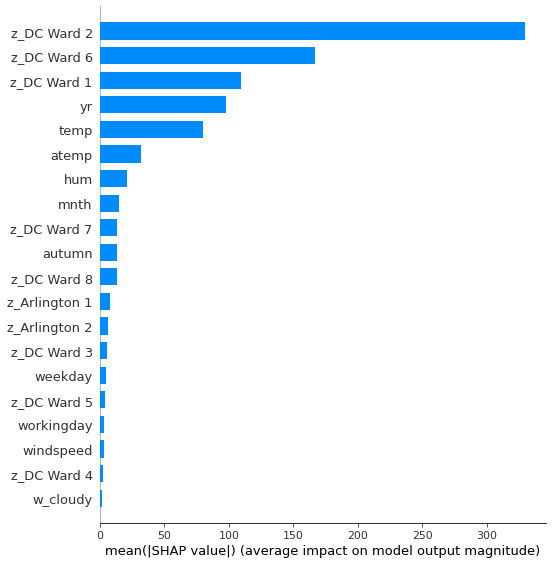

In [13]:
shap.summary_plot(rf_shap_values, X_train, plot_type="bar")

In [14]:
df_zones = df[["z_Arlington 1", "z_Arlington 2", "z_DC Ward 1", "z_DC Ward 2", "z_DC Ward 3", "z_DC Ward 4", "z_DC Ward 5", "z_DC Ward 6", "z_DC Ward 7", "z_DC Ward 8"]]
count_zones = df_zones.idxmax(axis=1)
df_count_zones = pd.DataFrame()
df_count_zones["zone"] = count_zones
df_count_zones["cnt"] = df["cnt"]
df_count_zones.groupby('zone').mean().round(2).sort_values(by="cnt", ascending=False)

cnt
zone                  
z_DC Ward 2    2047.15
z_DC Ward 6    1085.54
z_DC Ward 1     729.29
z_Arlington 1   134.30
z_Arlington 2   131.56
z_DC Ward 3     129.80
z_DC Ward 5     105.70
z_DC Ward 4      67.25
z_DC Ward 7      14.52
z_DC Ward 8       6.38

From the variable importance plot we can see that the top 3 variables that contribute more to the model and thus have high predictive power are zones features: *DC Ward 2*, *DC Ward 6* and *DC Ward 1*

Those zones represent the center of Washington DC with high density of stations and also of bikes rent, where the number of our CNT variables is higher rather than the rest of the map. In fact in these zones the mean value of cnt increase drastically as you can see above, so the shapely value tends to increase. 

It is self-explanatory the effect on our target variable.

We can also notice that the following zones features most important are: *z_DC Ward 7* and *z_DC Ward 8*

Unlike the firsts zone selected they returned a high feature importance for the opposite reason. Those zone have the lower count of the entire map and they are used by our model to lower the target variable

In order to better understand the rest of features we need to show the positive and negative relationships of the predictors with the cnt

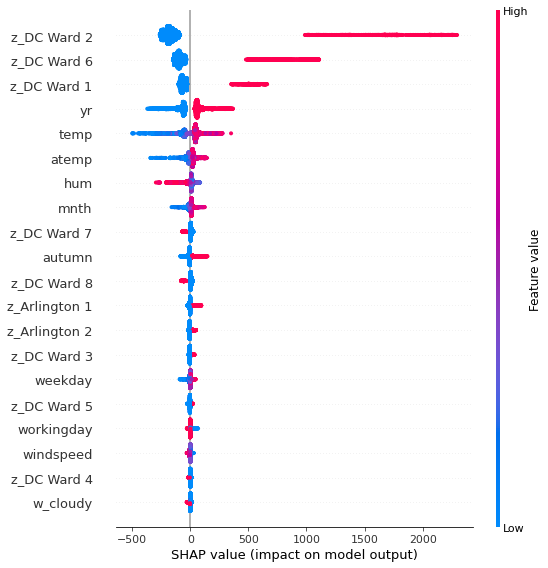

In [15]:
shap.summary_plot(rf_shap_values, X_train)

**Year** feature is immediately after, in this plot we can see the same year trend that we have previously observed. The blue and red values that represent 2011 and 2012 respectively are well separeted meaning that 2011 instances tend to lower our cnt, while 2012 tend to increase it. The company clearly increased the number of users in the second inspected year.


For the **temp** and **atemp** features we can observe that lower temperature decrese the number of bikes used while higher temperature increase it. Seems that it has a longer tail on the blue, meaning that lower temperature more affect the target variable than the higher temperature.

It is also interesting to observe how higher values of **humidity** decrease the number of bikes used, while lower values of humidity doesn't have the same powerful impact, also due to the normalization effect

## 21 zones


In [16]:
d = Bikes(geo_k=21)
df = d.geo_df_SD
X_train = d.d['x_train']
y_train = d.d['y_train']
X_test = d.d['x_test']
y_test = d.d['y_test']
cols_to_keep = [c for c in X_train.columns if c not in ["dteday",]]

X_train = X_train[cols_to_keep]
X_test = X_test[cols_to_keep]

X_train_arr = X_train.values
X_test_arr = X_test.values
# use the model inside of Bikes()
RF_reg = d.model["RF"]
y_pred = d.model["y_pred"]

Fitted a RFRegressor with R^2 0.950 and MSE 4864.9.


In [17]:
# ------- VERY INTENSIVE SHAP RUN ---------
# rf_shap_values = shap.TreeExplainer(RF_reg).shap_values(X_train)
# with open('/content/drive/Shareddrives/BigData_project/data/shapvalues.pickle', 'wb') as f:
#    pickle.dump(rf_shap_values, f)

We just load the shap values from a pickle we saved.

In [18]:
with open('/content/drive/Shareddrives/BigData_project/data/shapvalues.pickle','rb') as f:
    rf_shap_values = pickle.load(f)

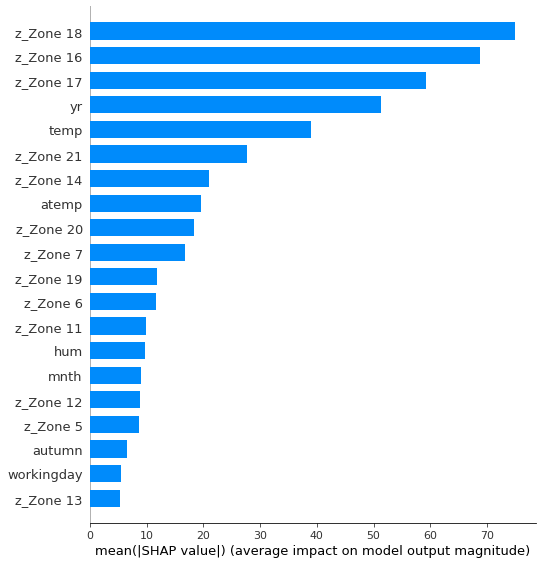

In [19]:
shap.summary_plot(rf_shap_values, X_train, plot_type="bar")

Features importance shows us that **z_zone 18**, **z_zone 17** and **z_zone 16** contribute mainly in predicting cnt being central zone of Washington with high density of stations and also of bikes rent. These 3 zones are contained into the previous most important zone **z_DC Ward 2** of the previous dataset

Both variable importance plots for global interpretability showed the same feature importance. The only clear difference we can observe is that with a fine grained granularity zones the density of small but higly used zones are preserved, consequently increasing its possibility to combine them with other available features

In [20]:
m = folium.Map(location=[geo_df['lat'].mean(), geo_df['long'].mean()],
               tiles='OpenStreetMap',
               zoom_start=13,
              )
geo4 = gpd.GeoSeries(part11.at[8,'geometry']).simplify(tolerance=0.001)
geo_j = geo4.to_json()
geo_j = folium.GeoJson(data=geo_j)
folium.Marker([part11.at[8,'geometry'].centroid.y,part11.at[8,'geometry'].centroid.x], icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(7,20),
        html=f'<div style="font-size: 18pt; color : darkblue">'+part11.at[8,'name']+'</div>',
        )).add_to(m)
geo_j.add_to(m)

geo4 = gpd.GeoSeries(part11.at[5,'geometry']).simplify(tolerance=0.001)
geo_j = geo4.to_json()
geo_j = folium.GeoJson(data=geo_j)
folium.Marker([part11.at[5,'geometry'].centroid.y,part11.at[5,'geometry'].centroid.x], icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(7,20),
        html=f'<div style="font-size: 18pt; color : darkblue">'+part11.at[5,'name']+'</div>',
        )).add_to(m)
geo_j.add_to(m)


style = {'fillColor': 'red', 'color': '#ff0000'}
geo14 = gpd.GeoSeries(part21.at[13,'geometry']).simplify(tolerance=0.001)
geo_j = geo14.to_json()
geo_j = folium.GeoJson(data=geo_j, style_function = lambda x: style)
folium.Marker([part21.at[13,'geometry'].centroid.y,part21.at[13,'geometry'].centroid.x], icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(7,20),
        html=f'<div style="font-size: 18pt; color : red">'+part21.at[13,'name']+'</div>',
        )).add_to(m)
geo_j.add_to(m)

m

In order to better understand the difference we can observe this case.
**DC Ward 4** and **Zone 14** are really similar but in the 11 zones dataset it returned a low feature importance while in the 21 zones dataset it returned an high feature importance. There might be two effects at play:

*   The left part of the DC Ward 4 lower the feature importance of the zone
*   The bottom part of the zone 4 increase the feature importance of the zone, since it takes part of the Washington DC center

In [21]:
inds = shap.approximate_interactions('mnth', rf_shap_values, X_train)
X_train.columns[inds]

Index(['z_Zone 17', 'z_Zone 16', 'z_Zone 21', 'yr', 'atemp', 'temp', 'hum',
       'workingday', 'z_Zone 12', 'w_cloudy', 'z_Zone 5', 'z_Zone 20',
       'windspeed', 'z_Zone 15', 'z_Zone 4', 'z_Zone 11', 'z_Zone 10',
       'z_Zone 14', 'z_Zone 8', 'weekday', 'z_Zone 19', 'z_Zone 9',
       'z_Zone 18', 'z_Zone 13', 'z_Zone 6', 'z_Zone 7', 'w_rain', 'z_Zone 2',
       'holiday', 'z_Zone 3', 'autumn', 'summer', 'spring', 'mnth'],
      dtype='object')

For the following analysis we focused on explaining 21 zones splitted model, because the 2 way of splitting give us similar results

Then we use dependence plot in order to see how SHAP value changes wrt the month. As you can see for the first quarter of the year this feature has a negative impact (also due to low temperature). In 2nd and 3th quarter it begin to increase promoted by high temperature which let cycling more enjoyable. However the shap values remain positive in the last quarter.

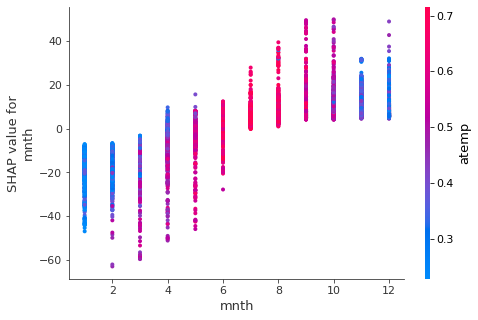

In [22]:
shap.dependence_plot('mnth', rf_shap_values, X_train, interaction_index=inds[4])

In [23]:
inds = shap.approximate_interactions('temp', rf_shap_values, X_train)
X_train.columns[inds]

Index(['z_Zone 16', 'z_Zone 17', 'z_Zone 18', 'z_Zone 10', 'z_Zone 15',
       'z_Zone 8', 'yr', 'z_Zone 9', 'z_Zone 6', 'hum', 'mnth', 'atemp',
       'windspeed', 'weekday', 'z_Zone 19', 'workingday', 'z_Zone 13',
       'w_cloudy', 'autumn', 'z_Zone 12', 'z_Zone 5', 'z_Zone 21', 'z_Zone 2',
       'spring', 'z_Zone 4', 'z_Zone 3', 'z_Zone 11', 'z_Zone 20', 'z_Zone 14',
       'z_Zone 7', 'summer', 'w_rain', 'holiday', 'temp'],
      dtype='object')

In [24]:
for i in range(2,22):
  print('Zone {} mean: {}'.format(i,y_train[X_train['z_Zone '+str(i)]==1].mean()))

Zone 2 mean: 46.76504297994269

Zone 3 mean: 7.625

Zone 4 mean: 61.52919708029197

Zone 5 mean: 130.1396103896104

Zone 6 mean: 176.91290322580645

Zone 7 mean: 243.44170771756978

Zone 8 mean: 2.88996138996139

Zone 9 mean: 3.801354401805869

Zone 10 mean: 5.46140350877193

Zone 11 mean: 151.216

Zone 12 mean: 127.8256

Zone 13 mean: 88.3170731707317

Zone 14 mean: 296.3253968253968

Zone 15 mean: 14.254934210526315

Zone 16 mean: 784.3471337579617

Zone 17 mean: 681.371382636656

Zone 18 mean: 876.3562091503268

Zone 19 mean: 181.87961476725522

Zone 20 mean: 261.06310679611653

Zone 21 mean: 373.8657937806874

The temperature too seems to have a positive
relationship with cnt. The dependence plot trend shows as with a low temperature under 0.5 (normalized) the feature has a negative impact on the predicted value. Taking into account also the Zone 16 feature you can see that absolute value of shap value increase a lot wrt other zone

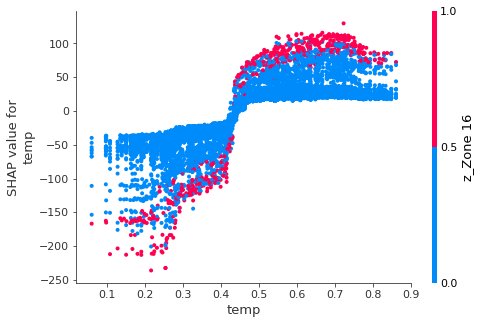

In [25]:
shap.dependence_plot('temp', rf_shap_values, X_train, interaction_index=inds[0])

Consider for example Zone 18 (with the highest mean cnt) the red point are more near to 0 shap value. Which means that low/high temperatures don't changes a lot the numer of bikes rent on average. Probably in Zone 18 there are more habitual users wrt Zone 16. 
On the other hand zone 16 (also 17) are the culture cornestone of Washington, conteining The White House and other monuments. So it the most attractive zone for tourist which explains the variability of bikes rent. 

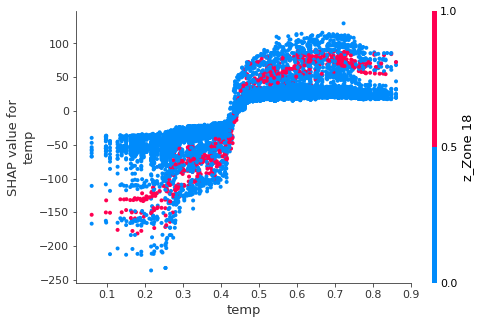

In [26]:
shap.dependence_plot('temp', rf_shap_values, X_train, interaction_index=inds[2])

In [27]:
m = folium.Map(location=[geo_df['lat'].mean(), geo_df['long'].mean()],
               tiles='OpenStreetMap',
               zoom_start=13,
              )
clr=['red', 'blue', 'green', 'purple', 'orange', 'darkred',
'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 
'gray', 'black', 'lightgray', 'darkblue', 'green']

        
for (i, row), c in zip(part21.iterrows(),clr):
    sim_geo = gpd.GeoSeries(row['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j)
    folium.Marker([row['geometry'].centroid.y,row['geometry'].centroid.x], icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(7,20),
        html=f'<div style="font-size: 18pt; color : darkblue">'+str(i+1)+'</div>',
        )).add_to(m)
    geo_j.add_to(m)
m

In [28]:
inds = shap.approximate_interactions('windspeed', rf_shap_values, X_train)
X_train.columns[inds]

Index(['z_Zone 16', 'z_Zone 18', 'atemp', 'temp', 'hum', 'mnth', 'yr',
       'z_Zone 21', 'weekday', 'w_cloudy', 'z_Zone 14', 'workingday', 'spring',
       'summer', 'z_Zone 10', 'autumn', 'z_Zone 8', 'z_Zone 15', 'z_Zone 20',
       'z_Zone 9', 'z_Zone 13', 'z_Zone 7', 'z_Zone 2', 'z_Zone 17',
       'z_Zone 19', 'z_Zone 11', 'z_Zone 4', 'z_Zone 12', 'z_Zone 5',
       'z_Zone 3', 'z_Zone 6', 'holiday', 'w_rain', 'windspeed'],
      dtype='object')

While windspeed has a negative linear relationship with cnt, as we can imagine with higher windspeed people are less inclined to take a bike.

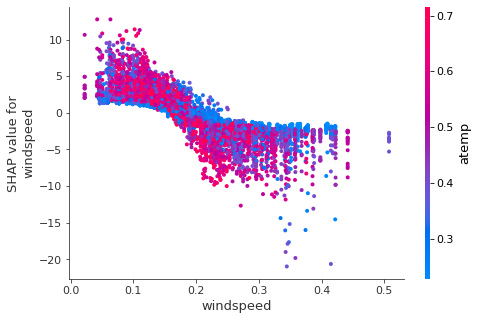

In [29]:
shap.dependence_plot('windspeed', rf_shap_values, X_train, interaction_index=inds[2])

# Local Explanations (21 zones)

For the local explainations part we decide to first take all the prediction, combining them with the test data.
After that we take the  value and put them into a csv without the indexing it

with this method we take all the predictions with the real index and we select a subset of that for making the explanations.

In [30]:
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(RF_reg.predict(X_output),2)
S_all = X_output
All_pred = S_all.to_csv('/content/drive/Shareddrives/BigData_project/data/mar_all_output.csv')

Here we can see the dataset where we select the subset for the explainations

In [31]:
S_all

yr  mnth  holiday  weekday  ...  z_Zone 9  w_cloudy  w_rain  predict
2       0     1        0        6  ...         0         1       0   178.93
3       0     1        0        6  ...         0         1       0     9.28
5       0     1        0        6  ...         0         1       0   199.20
15      0     1        0        0  ...         0         1       0    70.07
20      0     1        0        0  ...         0         1       0   436.39
...    ..   ...      ...      ...  ...       ...       ...     ...      ...
12950   1    12        0        6  ...         0         1       0   335.60
12956   1    12        0        6  ...         0         1       0    40.98
12989   1    12        0        1  ...         0         1       0     6.59
12994   1    12        0        1  ...         0         1       0    11.10
13003   1    12        0        1  ...         1         1       0     3.68

[1951 rows x 35 columns]

We take this functions for plotting the shape plot

In [32]:
# j is the value, S is the subset 
def shap_plot(j,S):
    explainerModel = shap.TreeExplainer(RF_reg)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

## Explanation by subsets
We decide to create three type of subste for understanding and analyzing well the single instance from  differents points of views. These are :     
 - zone_set = for the custom zone created
 - seas_set = for the explainations of seasonal effects on the istances
 - day_set = for analyzing better the single day and what rappresents for the instances

### Zones Explainer

We first decide to analyze the effect of the different zone on the predict value, for doing that we select this 4 test index ,retrieved from the csv 'S_all' and chosed manually for their importance.

In [33]:
zone_set = X_output.loc [[653,7725,11018,93]]
zone_set

yr  mnth  holiday  weekday  ...  z_Zone 9  w_cloudy  w_rain  predict
653     0     2        0        1  ...         0         0       0   485.66
7725    1     4        0        0  ...         0         0       0   158.59
11018   1     9        0        4  ...         0         1       0    55.01
93      0     1        0        5  ...         0         1       0     6.48

[4 rows x 35 columns]

The base value it is the value that would be predicted if we did not know any features for the current output , is the average of the model output over the training data X_train. So it is 249 for each shaplet_plot we do after, but as we know this value is not compleatly correct beacuse of the dummy features that are 0 or 1.

In [34]:
X_train.mean()

yr            0.548720
mnth          6.699539
holiday       0.028318
weekday       2.995567
workingday    0.685606
temp          0.501396
atemp         0.479844
hum           0.628243
windspeed     0.189054
spring        0.249525
summer        0.264634
autumn        0.256763
z_Zone 10     0.051570
z_Zone 11     0.056546
z_Zone 12     0.056546
z_Zone 13     0.048222
z_Zone 14     0.056998
z_Zone 15     0.055008
z_Zone 16     0.056817
z_Zone 17     0.056274
z_Zone 18     0.055370
z_Zone 19     0.056365
z_Zone 2      0.031575
z_Zone 20     0.055912
z_Zone 21     0.055279
z_Zone 3      0.019542
z_Zone 4      0.024790
z_Zone 5      0.055731
z_Zone 6      0.056093
z_Zone 7      0.055098
z_Zone 8      0.046865
z_Zone 9      0.040080
w_cloudy      0.336560
w_rain        0.025513
dtype: float64

In [35]:
shap.initjs()
shap_plot(0,zone_set)

The output value, f(x), is the prediction for that observation so  aproximated 486.
We want to focus on the zone features, for this plot, the corrisponding is 18, that in our map rappresents one of the zone of the center of whastington. Is intresting to observe the second most important features that pushs the predictions to this hight output value, 'hum', that for his normalization is equal to 0.378, one of the lowest value.

The features that push the prediction lower are the facts to belog to year = 0, so 2011, the temperature, that is not so much highter but almost below the average of normalization, ecc.. we can continue to analyze single features in this way.


In [36]:
shap.initjs()
shap_plot(1,zone_set)

For this other otuput value instead, that is lower than the first one, is special features is to belong to the area corresponding to the airport, in this case the hightest temperature, the year( that is 2012 in this case) push the prediction highter. But as you can see there are a lot of important features that push the prediction down including the fact that they do not belongs to the most populous areas, and also the fact to not belongs to a working day that push up the prediction, because, remembering the first distribution graph, this is one of the most rilevant part.

In [37]:
shap.initjs()
shap_plot(2,zone_set)

This time we want to explain another zone, The value is low but not so much like the next one, in this case, like before the facts to not belongs to the most populare zone , in the center, infer the prediction, the selected zone is Alexandria, a city near whastington. Here we can observe how features like year, hight temperature and perceived temperature,the month also ( that is September) try to push up the output value but not too much.

In [38]:
shap.initjs()
shap_plot(3,zone_set)

Last predictions reguards one of the most 'not popular' zone the 15, that corrispond to the Universitary Zone, we dosn't expect this lower value, but we notice that is a cold winter day of January, it was a Friday, it's a cloudy day, so maybe the student's did not frequent the area.

### Seasonal Explainer

For this part we decide to analyze the most popular season, summer and autumn on the predict value, for doing that we select this 4 test index, retrieved from the csv 'S_all' and chosed manually for their's importance.

In [39]:
seas_set = X_output.loc[[3848,4008,11747,12083]]
seas_set

yr  mnth  holiday  weekday  ...  z_Zone 9  w_cloudy  w_rain  predict
3848    0     9        0        0  ...         0         0       0  1037.25
4008    0     9        0        3  ...         0         0       0    63.56
11747   1    11        0        4  ...         0         1       0    59.90
12083   1    11        0        6  ...         0         0       0   131.05

[4 rows x 35 columns]

In [40]:
shap.initjs()
shap_plot(0,seas_set)

This prediction is one of the hightest that we have, it is the combination of one of the most popular zone (18) and the facts to belong to summer, has an hight temperature and it is also a sunday, so it's full of tourists or local people  that maybe can use the service. Only the facts to have a year not equal to 1 (so 2012) push the prediction lower.

In [41]:
shap.initjs()
shap_plot(1,seas_set)

It's interesting to observe this other prediction, it's also a summer day, but in this case the facts to not belong to one of the most popular zone and to belong to the year 2011, infer to the prediction and push the output value down.

In [42]:
shap.initjs()
shap_plot(2,seas_set)

We want first to reports this prediction for autumn day, because although is not one of the most popular zone and  the fact to be in the second year, the value is similar to the previous one but in this case there is a lower temperature and is a cloudy day, meaning that not only the zone are important in our analysis.

In [43]:
shap.initjs()
shap_plot(3,seas_set)

This prediction value instead, is highter than the previous one , but always for the last speech of the zones his output value increase.

### Day type Explainer

For our final subset we decide to analyze a single day but with the detection of different zones, the 21 and the 9. The day chosen is a monday, so it's a strage value, because is an holiday day of May, for season spring.

In [44]:
day_set = X_output.loc[[8574,8581]]
day_set

yr  mnth  holiday  weekday  ...  z_Zone 9  w_cloudy  w_rain  predict
8574   1     5        1        1  ...         0         0       0   527.43
8581   1     5        1        1  ...         1         0       0     8.39

[2 rows x 35 columns]

In [45]:
shap.initjs()
shap_plot(0,day_set)

In [46]:
shap.initjs()
shap_plot(1,day_set)

 
Let's analyze the two plots: 
- We can now clearly observe that the zone infer positivly to the prediction
- The facts to have an hight temperature value, belong to year 2012, have a low hum value infer also positivly
- Instead the fact that is holiday day(not working day) infer negativly

At the end we can say that the zone are the most important features.

## Explanation by *Off-By* values

Obviously as our target *cnt* is **continuous** we cannot have an accuracy and we cannot say that a record has been "correctly" predicted or not, precisely. However, we realized that we can calculate how much our predictor is wrong for each instance (the error) and calculate a metric we're calling the **off-by value** which is $\left| \frac{error}{ground \ value} \right|$.

We also calculate the mean off-by value across the entire test dataset and use that to say whether we have a correct or wrong prediction. Our mean off-by value is:

In [ ]:
d = Bikes(geo_k=21)
x_test = d.d["x_test"].drop(columns="dteday")

In [ ]:
# ------- VERY INTENSIVE SHAP RUN ---------
# my_explainer = shap.TreeExplainer(d.model["RF"])
# shap_vals_test = my_explainer.shap_values(x_test)
# with open('/content/drive/Shareddrives/BigData_project/data/picks/explainer_test.pickle', 'wb') as f:
#     pickle.dump(my_explainer, f)
# with open('/content/drive/Shareddrives/BigData_project/data/picks/shapvalues_test.pickle', 'wb') as f:
#     pickle.dump(shap_vals_test, f)

In [ ]:
pred = d.model["y_pred"]
truth = d.d["y_test"]
df = d.d["x_test"].drop(columns="dteday")

df["off_by"] = round(abs((100*(pred-truth)/truth)), 2)
off_by = df['off_by'].mean()
print(f"The mean off-by value over the test dataset is {round(off_by, 2)} %")
threshold = round(off_by*3/4, 2)
print(f"Our treshold for a correct prediction is an off-by value of mean_off*3/4 = {threshold} %")
table = Table(title="Off-by table", show_header=True, header_style="bold magenta", caption_justify="left", caption=f"Threshold for 'Correct' is {threshold} %")
table.add_column("Row ID", justify="left")
table.add_column("Ground truth", justify="right")
table.add_column("Prediction", justify="right")
table.add_column("Off-by", style="green", justify="right")
table.add_column("Correct", style="green", justify="left")

In [ ]:
# in test there are rows: 2,5,15,30,54,8530,12882
row_to_explain = [2,15,30,54,8530,12882]

In [ ]:
for r in row_to_explain:
    pred = pd.Series(d.model["y_pred"], index=df.index)[r]
    off_by = df['off_by'][r]

    table.add_row(f"{r}",f"{d.d['y_test'][r]}",f"{round(pred)}",f"{off_by} %",str(off_by<threshold))

console.print(table)

So, in this section we explain the two instances with the minimum and maximum off-by values.

In [ ]:
min_row = df.nsmallest(6, 'off_by')
min_row

In [ ]:
min_set = X_output.loc[[8530]]
shap.initjs()
shap_plot(0,min_set)

Here we can explain the row with the minimum off-by value, as you can observe the value is really hight, the zone involved is one of the center of Washinghton, the year is the 2012, there is an hight temperature/precived temperature that push the prediction highter. But as you cas see the fact that is a Saturday of May, so not a working day ad also is not a summer period, therefore the presence of tourists or local peapole decrease the value of the prediction and of course there are the other polular zone that decrease the output value. 

So this istance is one of our best prediction beacuse of the minimum off-by value.

In [ ]:
max_row = df.nlargest(6, 'off_by')
max_row

In [ ]:
max_set = X_output.loc[[12882]]
shap.initjs()
shap_plot(0,max_set)

For this last istance, that has the maximum off-by value, so its prediction is completely wrong, we can observe that is a rainy day of December of 2012, there is a low temperature beacuse of course is a winter day, the zone involved is Alexandria, so one with the lowest number of instances. Moreover, the true count is very low (1) so possibly it will be harder to correctly learn the correct decision boundaries for the RF regressor, since the value is close to zero. Something else of note is that it is one of the relatively rare "rainy" days according to the weathersit variable (now, dummies).

## Explanation by aggregation

In [ ]:
with open('/content/drive/Shareddrives/BigData_project/data/picks/shapvalues_test.pickle','rb') as f:
    shap_vals_test = pickle.load(f)
COLUMN_NAMES = x_test.columns
BASE_VAL = 249.3

def analyze_col(col):
    if col[:2] == "z_":
        return "geo-zone"
    elif col in ("spring", "summer", "autumn"):
        return "season"
    elif col in ("yr", "mnth", "holiday", "weekday", "workingday"):
        return "date"
    elif (col[:2] == "w_") or (col in ("temp", "atemp", "hum", "windspeed")):
        return "weather"

def characterize_columns(df):
    results = []
    for col in df:
        results.append(analyze_col(col))
    return results

MY_TYPES = characterize_columns(x_test)
data = pd.DataFrame(shap_vals_test, columns=COLUMN_NAMES, index=x_test.index)

In [ ]:
# in test there are rows: 2,5,15,30,54,8530,12882
row_to_explain = 2

In [ ]:
buckets = {}
my_row = data.loc[row_to_explain, :]
for value, type_ in zip(my_row, MY_TYPES):
    try:
        buckets[type_] += value
    except KeyError:
        buckets[type_] = value
hist_values = pd.Series(buckets, name=row_to_explain)
print(f"[b]Aggregated shap values:[/]\n{round(hist_values.sort_index(), 2)}")
print(f"\n\n[b]For instance ID[/] {row_to_explain}:\nBase value\t\t\t{BASE_VAL} +\naggregated shap values\t\t{round(hist_values.sum(), 2)} =\n[red bold]cnt[/] prediction (rounded)\t{round(BASE_VAL + hist_values.sum())}\n")
hist_values.sort_index().plot.bar()

This was done for two reasons:

1. because the shap method takes mean dummies value so the "base value" might be slightly misleading (as it stems from an impossible instance). We think that aggregating the shap effect of each dummy category can show more solid results than just looking at each shap value for each dummy.
2. simply to look at the aggregate effect of categories of features to get better immediate insights on what are the factors that are more influential in the outcome prediction of an instance.

**Thank you for the attention.**

In [ ]:

!pip install jovian --upgrade --quiet
import jovian
jovian.commit(project='rental-bike-3thmidterm')